## Introduction:

The M5Prime library is not natively available in Python, and when you try to install it directly, some issues may arise. As a solution, I downloaded the package and installed it manually then using command line (bash). The library was developed by Sylvain Marié, a Senior Group Expert, who is still actively working on it. He plans to add more features to the library in the future. The development of M5Prime began in 2022, based on the articles written by Ross Quinlan (the creator of the original M5 algorithm) and others, following the same approach.

As a side note, in the theoretical method of M5P, categorical variables do not need to be transformed or encoded. However, this feature has not yet been fully implemented in the current version of the library, which is why encoding is still required for now.

I also used another dataset to evaluate the model’s performance on different data. This dataset is also related to the insurance domain, and the results were very promising. The reason for using a different dataset is that our current data contains many uniform features with little correlation between them. By testing on another dataset, I aimed to confirm the model's effectiveness and generalizability, which is discussed in the last section. 

It is also available in Weka, or through the rweka package in R, or directly from the Weka website/software

### Import Libraries

In [1]:
import numpy as np
from sklearn.impute import SimpleImputer
import m5py
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from datetime import datetime
from m5py import M5Prime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


### Read Dataset


In [2]:
df= pd.read_csv('data_project.csv')

In [3]:
df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,41.0,Female,1397.0,Divorced,1.0,Master's,Self-Employed,38.748086,Suburban,Basic,0.0,18,719.0,5,123.0,2019-11-19 15:21:39.078837,Poor,No,Weekly,Condo
1,37.0,Male,40871.0,Married,3.0,Bachelor's,Employed,6.089154,Rural,Premium,2.0,8,836.0,4,14.0,2020-03-12 15:21:39.078837,Average,Yes,Weekly,Condo
2,59.0,Male,45192.0,Married,3.0,PhD,Unemployed,18.291421,Suburban,Comprehensive,0.0,13,447.0,5,91.0,2022-03-14 15:21:39.078837,Average,Yes,Daily,House
3,57.0,Female,38720.0,Married,3.0,Bachelor's,Employed,27.537122,Suburban,Premium,1.0,15,375.0,2,47.0,2020-12-04 15:21:39.078837,Average,No,Rarely,Apartment
4,52.0,Male,57619.0,Single,0.0,PhD,Employed,66.274320,Rural,Basic,0.0,8,781.0,6,22.0,2023-08-24 15:21:39.078837,Good,Yes,Monthly,Apartment


In [4]:
df.shape

(27884, 20)

The dataset contains 27884 rows and 20 columns. Each row of the dataset contains information about one customer. 

Our objective is to find a way to estimate the value in the "Premium Amount	" column using the values in the other columns. We can do it for the historical data, then we will estimate Premium Amount	 for new customers, simply by asking for information like their age, sex, ...

* As we can see the policy start date contain times so we keep just the date 

In [5]:
# Convert to datetime format
df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
df['Policy Start Date'] = df['Policy Start Date'].dt.date

df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,41.0,Female,1397.0,Divorced,1.0,Master's,Self-Employed,38.748086,Suburban,Basic,0.0,18,719.0,5,123.0,2019-11-19,Poor,No,Weekly,Condo
1,37.0,Male,40871.0,Married,3.0,Bachelor's,Employed,6.089154,Rural,Premium,2.0,8,836.0,4,14.0,2020-03-12,Average,Yes,Weekly,Condo
2,59.0,Male,45192.0,Married,3.0,PhD,Unemployed,18.291421,Suburban,Comprehensive,0.0,13,447.0,5,91.0,2022-03-14,Average,Yes,Daily,House
3,57.0,Female,38720.0,Married,3.0,Bachelor's,Employed,27.537122,Suburban,Premium,1.0,15,375.0,2,47.0,2020-12-04,Average,No,Rarely,Apartment
4,52.0,Male,57619.0,Single,0.0,PhD,Employed,66.274320,Rural,Basic,0.0,8,781.0,6,22.0,2023-08-24,Good,Yes,Monthly,Apartment



To find a meaningful relationship and use the Policy start date as a feature, we need to convert it into periods such as years or days. I’ve chosen to use days specifically to avoid confusion, as some records may not exceed one year. If we convert those records to years, the result would be zero, which wouldn’t provide useful information. Hence, using days ensures that we can capture the full range of data without such issues.
* so, I’ve added a new feature named Duration in Days to represent this period more accurately.

In [6]:
# Calculate duration in days (from start date to today)
df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
df['Duration in Days'] = (datetime.now() - df['Policy Start Date']).dt.days

# for duration in years we use:
#df['Duration (Years)'] = df['Duration (Days)'] / 365

df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Duration in Days
0,41.0,Female,1397.0,Divorced,1.0,Master's,Self-Employed,38.748086,Suburban,Basic,...,18,719.0,5,123.0,2019-11-19,Poor,No,Weekly,Condo,1885
1,37.0,Male,40871.0,Married,3.0,Bachelor's,Employed,6.089154,Rural,Premium,...,8,836.0,4,14.0,2020-03-12,Average,Yes,Weekly,Condo,1771
2,59.0,Male,45192.0,Married,3.0,PhD,Unemployed,18.291421,Suburban,Comprehensive,...,13,447.0,5,91.0,2022-03-14,Average,Yes,Daily,House,1039
3,57.0,Female,38720.0,Married,3.0,Bachelor's,Employed,27.537122,Suburban,Premium,...,15,375.0,2,47.0,2020-12-04,Average,No,Rarely,Apartment,1504
4,52.0,Male,57619.0,Single,0.0,PhD,Employed,66.274320,Rural,Basic,...,8,781.0,6,22.0,2023-08-24,Good,Yes,Monthly,Apartment,511


In [7]:
df = df.drop(columns=['Policy Start Date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27884 entries, 0 to 27883
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   27438 non-null  float64
 1   Gender                27884 non-null  object 
 2   Annual Income         26469 non-null  float64
 3   Marital Status        27388 non-null  object 
 4   Number of Dependents  25131 non-null  float64
 5   Education Level       27884 non-null  object 
 6   Occupation            19827 non-null  object 
 7   Health Score          26832 non-null  float64
 8   Location              27884 non-null  object 
 9   Policy Type           27884 non-null  object 
 10  Previous Claims       19833 non-null  float64
 11  Vehicle Age           27884 non-null  int64  
 12  Credit Score          25148 non-null  float64
 13  Insurance Duration    27884 non-null  int64  
 14  Premium Amount        27705 non-null  float64
 15  Customer Feedback  

In [9]:
df.describe()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Duration in Days
count,27438.000000,26469.000000,25131.000000,26832.000000,19833.000000,27884.000000,25148.000000,27884.000000,27705.000000,27884.000000
mean,41.052846,41854.094941,1.997732,28.614766,0.990773,9.500574,574.484452,5.032599,964.852193,1062.641551
std,13.557021,35438.097894,1.416784,16.018846,1.000839,5.741471,159.329694,2.583674,907.706186,527.170856
min,18.000000,0.000000,0.000000,0.073717,0.000000,0.000000,300.000000,1.000000,0.000000,154.000000
25%,29.000000,13282.000000,1.000000,16.038741,0.000000,5.000000,436.000000,3.000000,286.000000,605.000000
50%,41.000000,32011.000000,2.000000,26.449777,1.000000,10.000000,576.000000,5.000000,688.000000,1059.000000
75%,53.000000,61871.000000,3.000000,39.069269,2.000000,14.000000,711.000000,7.000000,1367.000000,1517.000000
max,64.000000,149992.000000,4.000000,92.773519,7.000000,19.000000,849.000000,9.000000,4999.000000,1979.000000


The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. The "Premium Amount" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.


> 1. The range of Annual Income	 in the numerical column seems to have lot of difference in 75 percentile and the maximun Annual Income	 it looks like outliers. So we will handle that outlierr.
> 2. The range of the  others numerical columns seems to have little difference in 75  percentile and the maximum bmi value.

In [10]:
df.describe(include="O")

,Gender,Marital Status,Education Level,Occupation,Location,Policy Type,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
count,27884,27388,27884,19827,27884,27884,26094,27884,27884,27884
unique,2,3,4,3,3,3,3,2,4,3
top,Male,Single,Bachelor's,Unemployed,Urban,Basic,Good,No,Daily,Apartment
freq,14048,9199,7101,6651,9327,9417,8768,13979,7000,9319


In [11]:
df.isnull().sum()

Age                      446
Gender                     0
Annual Income           1415
Marital Status           496
Number of Dependents    2753
Education Level            0
Occupation              8057
Health Score            1052
Location                   0
Policy Type                0
Previous Claims         8051
Vehicle Age                0
Credit Score            2736
Insurance Duration         0
Premium Amount           179
Customer Feedback       1790
Smoking Status             0
Exercise Frequency         0
Property Type              0
Duration in Days           0
dtype: int64

After analyzing the dataset, I found that several features have missing values. For some of these features, the proportion of missing data is significant (for example, the Occupation and Previous Claims columns have over 8,000 missing values, which accounts for a large portion of the data). Including these missing values could introduce bias into the model or reduce the model's performance 

In [12]:
# Remove rows with missing values
df= df.dropna()

In [13]:
df.shape

(9474, 20)

We can see also that there are many missing values we will ch


## Exploratory Analysis and Visualization

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "Premium Amount" and other columns.

We'll use libraries Matplotlib, Seaborn and Plotly for visualization.

### Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [14]:
fig = px.histogram(df, 
                   x='Age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset appears to be almost uniform, it should not introduce any particular bias into the model and should allow the model to learn from the data across the entire age spectrum

### Premium Amount


Let's visualize the distribution of "Premium Amount" i.e. the annual medical Premium Amount for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the Premium Amount for smokers and non-smokers.

In [15]:
fig = px.histogram(df,
                    x='Premium Amount',
                    marginal='box',
                    color='Occupation',
                    color_discrete_sequence=['green', 'orange', 'blue'],
                    title="Premium Amount By Occupation"
                    )
fig.update_layout(bargap=0.1)
fig.show()                   

The Premium Amount is similar for customers who are unemployed, self-employed, or employed. Additionally, the number of people in each category is roughly the same

### Gender 

Let us visualize the distribution of "Premium Amount" with the categorical column "Gender" to distinguish the Premium Amount for "male" and "female"

In [16]:
fig = px.histogram(df,
                    x="Premium Amount",
                    marginal="box",
                    color="Gender",
                    color_discrete_sequence=["blue", "purple"],
                    title="Premium Amount By Gender")

fig.update_layout(bargap=0.1)
fig.show()                    

The Premium Amount for both males and females appears to be uniform. They have approximately the same number of customers and similar boundary values

In [17]:
df.describe(include="O")

,Gender,Marital Status,Education Level,Occupation,Location,Policy Type,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
count,9474,9474,9474,9474,9474,9474,9474,9474,9474,9474
unique,2,3,4,3,3,3,3,2,4,3
top,Male,Divorced,Bachelor's,Unemployed,Urban,Basic,Average,Yes,Monthly,House
freq,4796,3168,2530,3235,3199,3203,3196,4746,2390,3177


### Distribution of Premium Amount with Region

Let's visualize the distribution of "Premium Amount" with categorical column "Location" to distinguish Premium Amount acoorfing to region

In [18]:
fig = px.histogram(df,
                    x="Premium Amount",
                    marginal="box",
                    color="Location",
                    color_discrete_sequence=["grey", "orange", "green"],
                    title="Premium Amount By region")

fig.update_layout(bargap=0.1)
fig.show()                    

We can also see that the Premium Amount for the three different regions is similarly distributed.

Let's Make further obesrvation

In [19]:
fig = px.pie(data_frame=df, names='Gender', values='Premium Amount', width=800, height=500, title='Premium Amount By Gender')
fig.show()

In [20]:
fig = px.pie(data_frame=df, names='Location', values='Premium Amount', width=800, height=500, title='Premium Amount By region')
fig.show()

## Remarks
* From the above results, we can observe that most of our features indicate a uniform distribution across the variables

In [21]:
df["Premium Amount"].corr(df.Age)

-0.014094246125788716

### One-hot Encoding
The features 'Gender', 'Marital Status', 'Occupation', 'Location', 'Property Type', and 'Smoking Status' are categorical variables without any inherent order (nominal). To ensure that the model correctly interprets these variables without introducing any ordinal relationships, I will use one-hot encoding. This method creates a separate binary column for each category, allowing the model to treat each category as independent.

<img src="https://miro.medium.com/max/1400/1*ggtP4a5YaRx6l09KQaYOnw.png" width="500">

In [22]:
# Apply One-Hot Encoding to categorical features
df = pd.get_dummies(df, columns=['Gender', 'Marital Status', 'Occupation', 'Location', 'Property Type', 'Smoking Status'])

### Label Encoding
The features 'Education Level', 'Policy Type', 'Customer Feedback', and 'Exercise Frequency' have an inherent order or ranking (ordinal data). For example, 'Education Level' follows a progression (e.g., High School < Bachelor's < Master's < PhD). Using label encoding allows us to assign numerical values that reflect this order, which helps the model understand the relative significance of the categories while keeping the data compact and efficient.

In [23]:
label_encoder = LabelEncoder()

df['Education Level'] = label_encoder.fit_transform(df['Education Level'])
df['Policy Type'] = label_encoder.fit_transform(df['Policy Type'])
df['Customer Feedback'] = label_encoder.fit_transform(df['Customer Feedback'])
df['Exercise Frequency'] = label_encoder.fit_transform(df['Exercise Frequency'])


### Correlation Matrix "Heatmap"

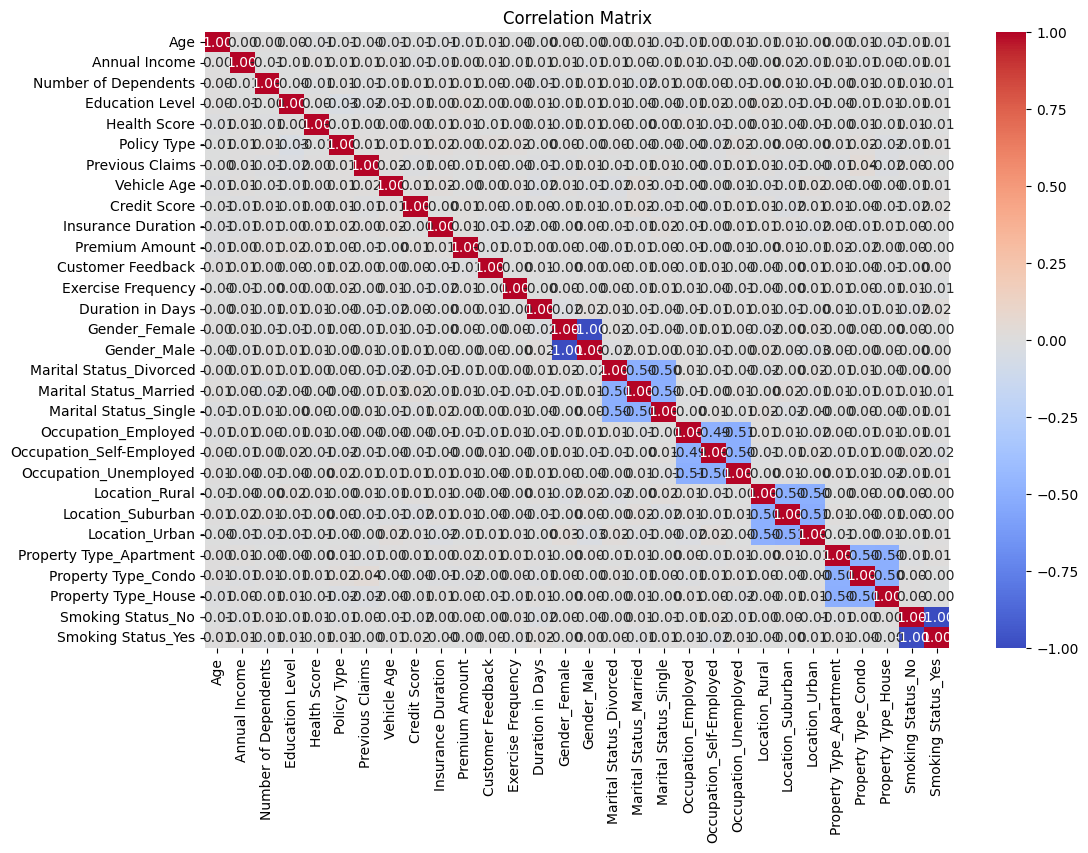

In [24]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Matrix")
plt.show()

We can see from the correlation matrix that most features are uncorrelated, except for those on which we applied label encoding. This correlation is logical since label encoding assigns numerical values based on an inherent order, naturally creating relationships between the encoded categories.

## M5prime 

As we know our target variable is "Premium Amount"

In [25]:
X = df.drop(columns=['Premium Amount'])  
y = df['Premium Amount'] 

In [26]:
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The M5' algorithm requires the input data to be in the form of a NumPy array. Therefore, we convert our dataset into a NumPy array to ensure compatibility with the algorithm.

In [27]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [28]:
# Verify the types
print("Type of X_train:", type(X_train))
print("Type of X_test:", type(X_test))
print("Type of y_train:", type(y_train))
print("Type of y_test:", type(y_test))

Type of X_train: <class 'numpy.ndarray'>
Type of X_test: <class 'numpy.ndarray'>
Type of y_train: <class 'numpy.ndarray'>
Type of y_test: <class 'numpy.ndarray'>


In [29]:
# Initialize the M5Prime model and fit
m5prime = M5Prime(max_depth=5)
m5prime.fit(X_train, y_train)


y_pred = m5prime.predict(X_test)

### Evaluation Of the performance

I would like to use cross-validation for evaluating the model to get a more robust measure of its performance. However, the library I am using does not currently include built-in support for cross-validation. And it's still under active development by its creators. As a result, certain features, such as cross-validation, are not yet implemented. To address this, I plan to implement cross-validation manually or use alternative techniques to evaluate the model effectively.

##### 1. Using Mean Squared Error

In [30]:
# Using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 827429.9922567307


##### 2. Using Root Mean Squared Error

In [31]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 909.6317893833365


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [33]:
from sklearn.metrics import r2_score

# Calculate R²
r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

R² Score: -0.008637965517865664


## Conclusion

In conclusion, when predicting the Premium Amount, the model's performance appears to be less optimal compared to other tasks. The R² score is not very high, suggesting that the model is not explaining a significant portion of the variance in the Premium Amount. Additionally, the Root Mean Squared Error (RMSE) of 909.63 indicates that the model's predictions deviate from the actual values by a considerable amount on average.

Despite performing several preprocessing steps and trying different approaches, such as handling missing values, encoding categorical features, and tuning the model, the results suggest that further improvements may be needed. This could involve refining the feature selection process, addressing the possible non-linearity of the relationships between features and the target, or exploring alternative models. The fact that the RMSE is still relatively high indicates that more work is required to improve prediction accuracy and better capture the complexities of the Premium Amount prediction.

### Apply M5' for another data

> Dataset source: [Kaggle](https://www.kaggle.com/noordeen/insurance-premium-prediction)
> 

In [448]:
# Let us load the dataset
df1 = pd.read_csv("insurance.csv")

In [449]:
df1.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer. 

Our objective is to find a way to estimate the value in the "expenses" column using the values in the other columns. We can do it for the historical data, then we will estimate expenses for new customers, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

In [450]:
# Let us see statistical information about the Numerical features
df1.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [451]:
# Let us see more statiscal information of the categorical features 
df1.describe(include="O")

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [453]:
# Apply One-Hot Encoding to categorical features
df1 = pd.get_dummies(df, columns=['sex', 'smoker', 'region'])

In [455]:
X = df1.drop(columns=['expenses'])  
y = df1['expenses'] 

In [456]:
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [457]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [458]:
# Initialize the M5Prime model and fit
m5prime = M5Prime(max_depth=5)
m5prime.fit(X_train, y_train)


y_pred = m5prime.predict(X_test)

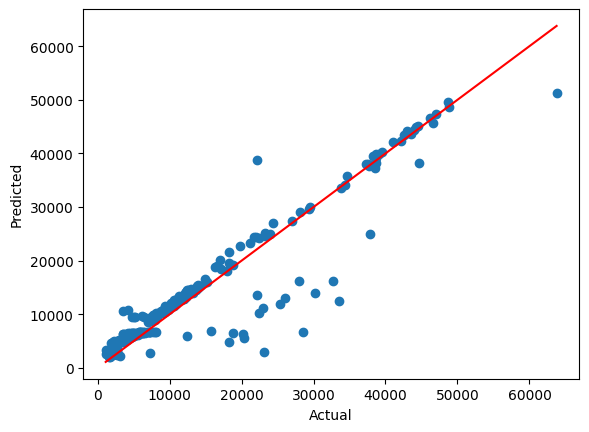

In [460]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Ideal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


In [461]:
# Calculate R²
r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

R² Score: 0.8821164594312159


### Conclusion

By applying the M5P decision tree model to predict annual medical expenses using a different dataset, we can observe a similar strong performance. The model achieved a high R² score of 0.882, meaning it explains approximately 88% of the variance in the predicted expenses. This indicates that the M5P model is effectively capturing the relationships between the features and the target variable, even with the unique characteristics of the new dataset. The positive result confirms that the model is generalizable and performs well across different insurance-related datasets, demonstrating its versatility and reliability in predicting expenses accurately.